In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Adjoint methods
## Background
We will assume that we have  a set of "free" parameters that we can use for optimization, $p_\alpha$,  variables that are updated by our numerical code, $x_\beta$, and  a function the we want to optimize, $H(p_\alpha, x_\beta)$.

Since we know that the $x_\beta$'s follows the $l_\gamma$'s we can the we can add these as Lagrange multiplier without affecting the variation, meaning that 
\begin{equation*}
    \mathrm{d}L = \mathrm{d}H + \sum_\gamma\lambda_\gamma\mathrm{d}l_\gamma,
\end{equation*}
will give the same minimum as $\mathrm{d}H = 0$.

The point now is to choose the $\lambda$'s so that we remove the $\mathrm{d}x_\beta$-dependence from the variation.
\begin{align*}
    \mathrm{d}L &= \sum_\alpha\frac{\partial H}{\partial p_\alpha}\mathrm{d}p_\alpha + \sum_\beta\frac{\partial H}{\partial x_\beta}\mathrm{d}x_\beta + \sum_\gamma\lambda_\gamma\left(\sum_\alpha\frac{\partial l_\gamma}{\partial p_\alpha}\mathrm{d}p_\alpha + \sum_\beta\frac{\partial l_\gamma}{\partial x_\beta}\mathrm{d}x_\beta\right) \\
    &= \sum_\alpha\left(\frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}\right)\mathrm{d}p_\alpha + \sum_\beta\left(\frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta}\right)\mathrm{d}x_\beta.
\end{align*}
We can now choose the $\lambda$'s so that 
$$
    \frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta} = 0,
$$ 
and we are left with
\begin{equation*}
\mathrm{d}L = \sum_\alpha\left(\frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}\right)\mathrm{d}p_\alpha.
\end{equation*}
The challenge is to setup and solve the set of equations for the Lagrange multipliers.

# Diffusion
The equation we solve is the simple diffusion equation
\begin{align*}
\frac{\partial \phi}{\partial t} = \nabla\left(D\nabla\phi\right),
\end{align*}
and 
$$
\mathbf{n}\cdot\nabla\phi = 0,
$$
for the solid boundaries and
$$
 \phi(\mathbf{x}, t) = h(\mathbf{x}),
$$
for the "inlet" and "outlet" boundaries.

## Lattice Boltzmann
We will setup an LB simulation where we add a parameter to fix the flux, so that we can easily implement an immersed boundary methods for the zero flux Neumann boundary conditions. The immersed boundary method was taken from the multi-phase lattice Boltzmann solver from A. Riaud et al. [Phys. Rev. E 89, 053308 (2014)].
\begin{align*}
 g_\alpha(\mathbf{x} + \mathbf{c}_\alpha, t + 1) &= g_\alpha(\mathbf{x}, t) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}, t) - g_\alpha^\mathrm{eq}(\mathbf{x}, t)\right) + w_\alpha \beta_s(1-x)\phi\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|} \\
 &= g_\alpha(\mathbf{x}, t) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}, t) - g_\alpha^\mathrm{eq}(\mathbf{x}, t)\right) + R_\alpha(\mathbf{x})\phi
\end{align*}
where $g_\alpha^\mathrm{eq} = w_\alpha\phi$, and
$$
\lambda_s = \frac{\tau\beta_sk\xi}{D}.
$$
The $k$ is defined by the expression
$$
2k\delta_{ij} = \sum_\alpha w_\alpha\frac{c_{\alpha i}c_{\alpha j}}{|\mathbf{c}_\alpha|}.
$$
For d2q9 $k \approx 0.150$.  $\lambda_s$ seems to be treated as a "sort of" free parameter but seems to bo chosen as $\lambda_s = 1$ for examples when a diffusive field is restricted to just one region.

$\xi$ is defined by the width of the surface witch is given by
$$
x = 1/2\left(1 - \tanh(d/\xi)\right),
$$
where $d$ is the signed distance function, $d < 0$ defines the domain.

### Boundary condition (left and right hand side)
Here we use a simple bounce back to set the inlet and outlet concentrations:
$$
g_{\overline{\alpha}} + g_\alpha = 2w_\alpha\phi,
$$ 
where $\mathbf{c}_{\overline{\alpha}} = - \mathbf{c}_\alpha$.

### Boundary condition (top bottom)
Periodic



## Test of the LB scheme

Standard propagate function:

In [28]:
def circ_shift(valin, c_input):
    valout = valin
    for d, c in enumerate(c_input):
        valout = np.roll(valout, c, axis=d)
    return valout

def propagate(f, c_input):
    for q, c in enumerate(c_input):
        f[q, ...] = circ_shift(f[q, ...], c)
    return f
  

Setup the lattice:

In [29]:
c = np.array([[0, 0], [1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [-1, -1], [1, -1], [-1, 1]], dtype=int)
w = np.array([4/9] + [1/9]*4 + [1/36]*4)

#### Test case

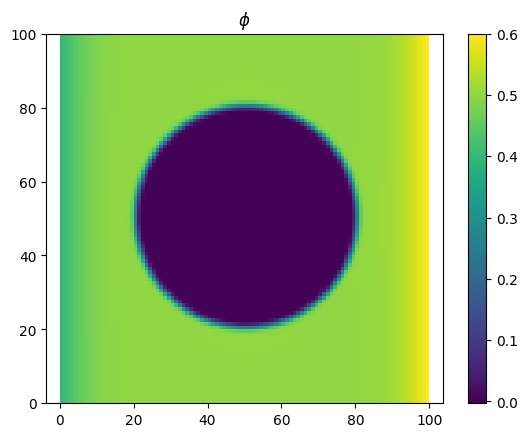

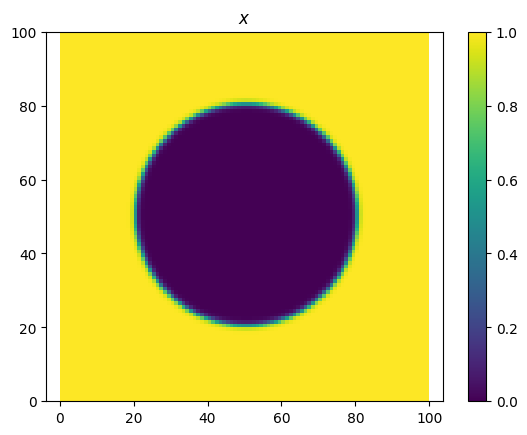

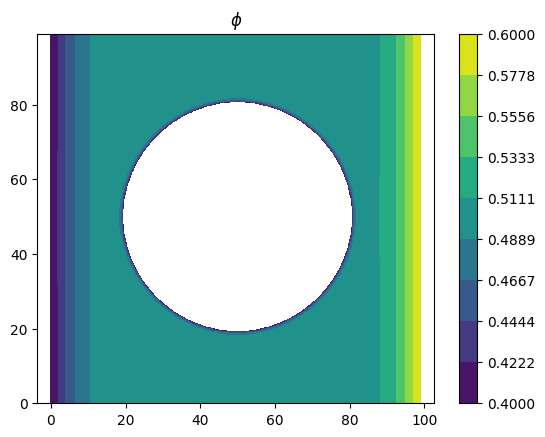

In [30]:
system_size = (100, 100)
tau = 1.2
xi = 0.8
gamma_s = 1.0

k = 0.150
D = (tau - 0.5)/3
beta_s = gamma_s*D/(k*xi*tau)


# set up solid geometry
X, Y = np.mgrid[:system_size[0], :system_size[1]]
X = X-system_size[0]/2
Y = Y-system_size[1]/2
d = 30 - np.sqrt( X**2 + Y**2 )

x = 0.5*(1-np.tanh(d/xi))

# Init system
phi= 0.5*np.ones(system_size)*x
g = w.reshape(9,1,1)*phi
g_out = np.zeros((9,)+system_size)

# normal vectors
N = np.zeros( system_size + (2,))
N[1:-1,1:-1,0] = -0.5*(d[2:,1:-1] - d[:-2,1:-1]) 
N[1:-1,1:-1,1] = -0.5*(d[1:-1, 2:] - d[1:-1,:-2]) 
N[1:-1,1:-1,:] /= np.sqrt( np.sum(N[1:-1,1:-1,:]**2, axis=-1, keepdims=True) ) + 1e-10

# Calculate the flux source term for imposing the no-flux boundary condition
cnorm = c / (np.sqrt( np.sum(c**2, axis=-1, keepdims= True)) + 1e-10)
cnorm_dot_N = np.sum(cnorm.reshape(9,1,1,2)*N.reshape((1,)+N.shape), axis=-1)
source_const = w.reshape(9,1,1)*beta_s*(1-x).reshape((1,)+x.shape)*cnorm_dot_N

# Main loop
for iter in np.arange(100):
    # Collision
    phi = np.sum(g, axis=0)
    g_out = (1-1/tau)*g + (1/tau)*w.reshape(9,1,1)*phi  + source_const*phi.reshape((1,)+phi.shape)

    # Propagation
    g = propagate(g_out, c)

    # Boundary conditions
    # -- left hand side
    for dir in [5, 1, 7]:
        g[dir, 0, :] = 2*w[dir]*0.4 - g[dir+1, 0, :]

    # -- Right hand side
    for dir in [8, 2, 6]:
        g[dir, -1, :] = 2*w[dir]*0.6 - g[dir-1, -1, :]

# Plots
plt.figure()
plt.title(r"$\phi$")
plt.pcolormesh(phi.transpose())
plt.axis("equal")
plt.colorbar()

plt.figure()
plt.title(r"$x$")
plt.pcolormesh(x.transpose())
plt.axis("equal")
plt.colorbar()

plt.figure()
plt.title(r"$\phi$")
plt.contourf(phi.transpose(), np.linspace(0.4, 0.6, 10))
plt.axis("equal")
plt.colorbar()


plt.show()
    

## Time independent LB simulations

We assume that the system is run to its stationary state, so that the lattice Boltzmann equations define a fix-point iteration scheme:
$$
g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) = g_\alpha(\mathbf{x}) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}) - g_\alpha^\mathrm{eq}(\mathbf{x})\right) + R_\alpha(\mathbf{x}),
$$
together with the boundary conditions 
$$
g_{\overline{\alpha}}(\mathbf{x}) + g_\alpha(\mathbf{x}) = 2w_\alpha x\,\phi_\mathrm{x},
$$
We can solve also solve this as a fix-point equation.


## Calculation of derivatives

Definition of the system of equations for the bulk properties:
$$
l_\alpha(\mathbf{x}) = g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) - \left(g_\alpha(\mathbf{x}) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}) - g_\alpha^\mathrm{eq}(\mathbf{x})\right) +  R_\alpha(\mathbf{x})\phi\right),
$$
The variation with respect to $g_\alpha$
\begin{align*}
\mathrm{d}_g l_\alpha(\mathbf{x}) &= \mathrm{d}g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) - \left(\left( 1 - \frac{1}{\tau}\right)\mathrm{d}g_\alpha(\mathbf{x}) + \frac{w_\alpha}{\tau}\mathrm{d}\phi + R_\alpha(\mathbf{x})\mathrm{d}\phi\right)\\
&=\mathrm{d}g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) - \left(\left( 1 - \frac{1}{\tau}\right)\mathrm{d}g_\alpha(\mathbf{x}) + \left(\frac{w_\alpha}{\tau} +  R_\alpha(\mathbf{x})\right)\mathrm{d}\phi\right),
\end{align*}
where
$$
\mathrm{d}\phi = \sum_\alpha \mathrm{d}g_\alpha(\mathbf{x})
$$

### Implementation of the bulk variance for $g_\alpha$
We can simplify the notation to
$$
\mathrm{d}g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) + a(\tau)\,\mathrm{d}g_\alpha(\mathbf{x}) + b(w_\alpha, \mathbf{c}_\alpha, \mathbf{n}, \tau, \beta_s, x)\,\mathrm{d}\phi,
$$
where
\begin{align*}
a&(\tau) = -\left( 1 - \frac{1}{\tau}\right) \\
b& (w_\alpha, \mathbf{c}_\alpha, \mathbf{n}, \tau, \beta_s, x) = -w_\alpha\left(\frac{1}{\tau} + \beta_s(1-x)\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|}\right)  = -\left(\frac{w_\alpha}{\tau} +  R_\alpha(\mathbf{x})\right)\mathrm{d}\phi
\end{align*}

In [38]:
def sub2ind(sub, system_size):
    return int(sub[0]*system_size[1] + np.mod(sub[1], system_size[1]))

gamma = 3
sub = np.array((3,4))
c_alpha = c[gamma]

# list of index
beta = np.array([9*sub2ind(sub+c_alpha, system_size) + gamma, 9*sub2ind(sub, system_size) + gamma] + [9*sub2ind(sub+c[q], system_size) + q for q in np.arange(9)]) 
a = -(1-1/tau)
b = -(w[gamma]/tau + source_const[(gamma,) + tuple(sub)])
val = np.array([1, a] + 9*[b])




## Old text

In this setup we have that the flux, $\mathbf{j}$, is given as
$$
  \mathbf{j} = \left(1-\frac{1}{2\tau}\right)\sum_\alpha g_\alpha\mathbf{c}_\alpha + \frac{1}{2}\mathbf{q}.
$$
We want that $\mathbf{q} = 0$ except at the solid boundary where,
$$
\mathbf{n}\cdot\mathbf{q} = -2\left(1-\frac{1}{2\tau}\right)\sum_\alpha g_\alpha\mathbf{n}\cdot\mathbf{c}_\alpha,
$$
so that $\mathbf{n}\cdot\mathbf{j} = 0$.

For the inlet/outlet boundary conditions we will use a simple bounce back boundary condition. From the Chapman-Enskog procedure we get that,
$$
g_\alpha^\mathrm{neq} = \tau w_\alpha c_{\alpha, i}\left(\frac{q_i}{c_s^2}-\frac{\partial\phi}{\partial x_i}\right),
$$
that that
$$
g_\alpha + g_{\overline{\alpha}} = 2w_\alpha\phi,
$$
where $\mathbf{c}_{\overline{\alpha}} = -\mathbf{c}_\alpha$.

\begin{align*}
\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= \sum_\alpha c_{\alpha i}\tau w_\alpha c_{\alpha, j}\left(\frac{q_j}{c_s^2}-\frac{\partial\phi}{\partial x_j}\right) \\
\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= \tau c_s^2\delta_{ij}\left(\frac{q_j}{c_s^2}-\frac{\partial\phi}{\partial x_j}\right) \\
\frac{1}{\tau}\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= c_s^2\left(\frac{q_i}{c_s^2}-\frac{\partial\phi}{\partial x_i}\right) \\
\frac{1}{\tau}\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= q_i-c_s^2\frac{\partial\phi}{\partial x_i} \\
q_i - \frac{1}{\tau}\sum_\alpha c_{\alpha i} g_\alpha^\mathrm{neq} &= c_s^2\frac{\partial\phi}{\partial x_i} \\
\end{align*}